This tutorial can be downloaded [link](https://github.com/west-code-development/West/raw/master/Doc/tutorials/basic/basic_007.ipynb).

# Intro tutorial 7: Computing absorption spectra by solving the Bethe-Salpeter Equation (BSE) using density matrix perturbation theory (DMPT)

This tutorial shows how to compute the absorption spectrum of the $C_{60}$ molecule by solving the Bethe-Salpeter Equation (BSE) using the density matrix perturbation theory (DMPT).

WEST implements two distinct methods to compute the dielectric screening for the BSE solver:

- the projective dielectric eigenpotentials (PDEP) technique, which builds a low rank representation of the static dielectric matrix that enters the screened Coulomb interaction, the random phase approximation (RPA) is used;
- the finite field (FF) method, which allows for efficient calculations within and beyond the RPA.

Both methods circumvent the explicit computation of empty electronic states and the storage and inversion of large matrices.

In addition, the computational cost can be reduced by using a localized representation of the ground state Kohn-Sham wavefunctions.

This tutorial focuses on the PDEP-based method as described in [Rocca et al., J. Chem. Phys. 133, 164109 (2010)](https://doi.org/10.1063/1.3494540) and [Rocca et al., Phys. Rev. B 85, 045116 (2012)](https://doi.org/10.1103/PhysRevB.85.045116).

The FF-based method is covered in [Tutorial 8](https://github.com/west-code-development/West/raw/master/Doc/tutorials/basic/basic_008.ipynb).

## Step 1:  Mean-field starting point

We first perform the mean-field electronic structure calculation within DFT using the [Quantum ESPRESSO](https://www.quantum-espresso.org/) code.

Download the following files to your working directory:

In [1]:
%%bash
wget -N -q http://www.quantum-simulation.org/potentials/sg15_oncv/upf/C_ONCV_PBE-1.2.upf
wget -N -q https://west-code.org/doc/training/C60_pdep/pw.in
wget -N -q https://west-code.org/doc/training/C60_pdep/nscf.in

We can inspect the `pw.in` file, the input for the `pw.x` code:

In [2]:
%%bash
cat pw.in

&control
pseudo_dir = './'
calculation = 'scf'
wf_collect = .TRUE.
/
&system
ibrav = 0
ntyp = 1
nat = 60
ecutwfc = 20
/
&electrons
diago_full_acc = .TRUE.
/
ATOMIC_SPECIES
C 14 C_ONCV_PBE-1.2.upf
ATOMIC_POSITIONS bohr
C  6.560216999227  1.317708999068  0.000000000000
C  5.716322000011  2.686502999941 -2.213027000418
C  6.560216999227 -1.317708999068  0.000000000000
C  4.900061000384  1.363055000501 -4.347289999376
C  2.686503999607  2.213028000083 -5.716321000346
C  4.347291000932  4.900060000718 -1.363055000501
C  2.213028000083  5.716322000011 -2.686502000276
C  1.363056000166  4.347291000932 -4.900058999163
C  4.900058999163 -1.363055000501  4.347289999376
C  4.900058999163  1.363055000501  4.347289999376
C  5.716321000346 -2.686502999941  2.213027000418
C  5.716321000346  2.686502999941  2.213027000418
C  4.347291000932  4.900060000718  1.363055000501
C  2.686501000610  2.213028000083  5.716321000346
C  1.363054000835  4.347291000932  4.900058999163
C  2.213027000418  5.71632200001

We run `pw.x` on 32 cores.

In [ ]:
%%bash
mpirun -n 32 pw.x -i pw.in > pw.out

To include a few unoccupied bands (in this case 800 bands in total) we run a non-self-consistent calculation. The content of `nscf.in` is almost identical to that of `pw.in`, except that in `nscf.in` we request a non-self-consistent calculation with empty bands.

We run `pw.x` again on 32 cores.

In [ ]:
%%bash
mpirun -n 32 pw.x -i nscf.in > nscf.out

## Step 2: Calculation of dielectric screening

As detailed in [Tutorial 1](https://github.com/west-code-development/West/raw/master/Doc/tutorials/basic/basic_001.ipynb), the static dielectric screening is computed using the projective dielectric eigendecomposition (PDEP) technique. Download the following file to your working directory:

In [3]:
%%bash
wget -N -q https://west-code.org/doc/training/C60_pdep/wstat.in

Let us inspect the `wstat.in` file:

In [4]:
%%bash
cat wstat.in

input_west:
  outdir: ./

wstat_control:
  wstat_calculation: S
  n_pdep_eigen: 720


We run `wstat.x` on 512 cores:

In [ ]:
%%bash
mpirun -n 512 ./wstat.x -ni 16 -i wstat.in > wstat.out

## Step 3: BSE calculation

### Step 3.1: BSE initialization

We perform a initialization step to compute the screened exchange integrals using the `wbse_init.x` executable. Download the following file to your working directory:

In [5]:
%%bash
wget -N -q https://west-code.org/doc/training/C60_pdep/wbse_init.in

Let us inspect the `wbse_init.in` file:

In [6]:
%%bash
cat wbse_init.in

input_west:
  outdir: ./

wbse_init_control:
  wbse_init_calculation: S
  bse_method: PDEP
  n_pdep_eigen_to_use: 720
  localization: W
  overlap_thr: 0.001


The `bse_method: PDEP` keyword selects the PDEP method. A total number of `n_pdep_eigen_to_use: 720` PDEPs is used to represent the static dielectric matrix. The `localization: W` keyword instructs the code to use Wannier functions, which are a localized representation of the Kohn-Sham wavefunctions. If the overlap between two Wannier functions is below `overlap_thr: 0.001`, the evaluation of the corresponding screened exchange integral is skipped, thus reducing the computational cost.

We run `wbse_init.x` on 512 cores:

In [ ]:
%%bash
mpirun -n 512 ./wbse_init.x -ni 16 -i wbse_init.in > wbse_init.out

### Step 3.2: BSE absorption spectrum

Now we run the `wbse.x` executable to compute the absorption spectrum of $C_{60}$. Download the following file to your working directory:

In [7]:
%%bash
wget -N -q https://west-code.org/doc/training/C60_pdep/wbse.in

Let us inspect the `wbse.in` file:

In [8]:
%%bash
cat wbse.in

input_west:
  outdir: ./

wbse_init_control:
  wbse_init_calculation: S
  bse_method: PDEP
  n_pdep_eigen_to_use: 720
  localization: W
  overlap_thr: 0.001

wbse_control:
  wbse_calculation: L
  qp_correction: west.wfreq.save/wfreq.json
  wbse_ipol: XYZ
  n_lanczos: 1300


The `wbse_calculation: L` keyword instructs the code to compute the absorption spectrum using the Lanczos algorithm. The `wbse_ipol: XYZ` keyword specifies which components of the polarizability tensor are computed, where `XYZ` means that three Lanczos chains are sequentially performed to compute the full polarizability tensor.

The `qp_correction` keyword indicates the name of the JSON file that contains the quasiparticle correction. This file is obtained from a GW calculation following the steps in [Tutorial 1](https://github.com/west-code-development/West/raw/master/Doc/tutorials/basic/basic_001.ipynb). An example `wfreq.json` file can be downloaded as:

In [9]:
%%bash
mkdir -p west.wfreq.save
wget -N -q https://west-code.org/doc/training/C60_pdep/wfreq.json -O west.wfreq.save/wfreq.json

Alternatively, a scissors operator may be applied to model the quasiparticle correction, by simply replacing the `qp_correction` keyword with the `scissor_ope` keyword.

We now run `wbse.x` on 512 cores:

In [ ]:
%%bash
mpirun -n 512 ./wbse.x -ni 16 -i wbse.in > wbse.out

The output can be found in the file `west.wbse.save/wbse.json`. If the reader does NOT have the computational resources to run the calculations, the output file can be directly downloaded as:

In [10]:
%%bash
mkdir -p west.wbse.save
wget -N -q https://west-code.org/doc/training/C60_pdep/wbse.json -O west.wbse.save/wbse.json

We use WESTpy to parse this file and plot the absorption coefficient as a function of the photon frequency.

 
 _    _ _____ _____ _____            
| |  | |  ___/  ___|_   _|           
| |  | | |__ \ `--.  | |_ __  _   _  
| |/\| |  __| `--. \ | | '_ \| | | | 
\  /\  / |___/\__/ / | | |_) | |_| | 
 \/  \/\____/\____/  \_/ .__/ \__, | 
                       | |     __/ | 
                       |_|    |___/  
 
WEST version     :  5.2.0
Today            :  2023-02-23 14:48:23.237369
output written in :  chi_XYZ.png
waiting for user to close image preview...


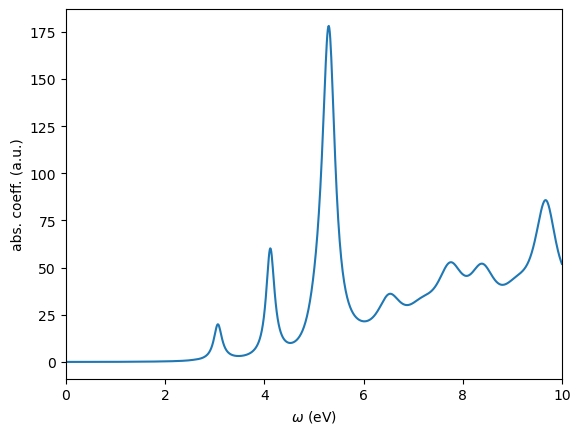

In [11]:
from westpy.bse import *

wbse = BSEResult("west.wbse.save/wbse.json")
wbse.plotSpectrum(ipol="XYZ",energyRange=[0.0,10.0,0.01],sigma=0.1,n_extra=98700)